In [104]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import glob
import PIL 

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

# function to get the file path, according to the label, up_down and video_index
def get_file_path(label, up_down, video_index):

    if label == 'correct':
        image_dir = '../images/correct_seq'
        corr_inc = 'cor'
    elif label == 'incorrect':
        image_dir = '../images/wrong_seq'
        corr_inc = 'inc'
    else:
        print('Label not found')
        exit()

    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # In case there is more than one
    if len(matching_files) > 1:
        print('More than one file found')
        exit()
    # But, there should be only one
    file_path = matching_files[0]
    
    return file_path 

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def calculate_angle_2D(m, p1, p2, p3):
    
    point1 = (m[p1][0],m[p1][1])
    point2 = (m[p2][0],m[p2][1])
    point3 = (m[p3][0],m[p3][1])

    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def calculate_angle_3D(point1, point2, point3):
    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1], point3[2] - point2[2]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1] + vector_21[2]*vector_23[2]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2 + vector_21[2]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2 + vector_23[2]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def angle_analysis(image, pose):

    model_path = 'pose_landmarker_heavy.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
    
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to visualize.
        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]

            # Draw the pose landmarks.
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])

        m = np.zeros((33,3))

        for i in range(33):
          pose_landmark = pose_landmarks_list[0][i]
          m[i][0] = float(pose_landmark.x)
          m[i][1] = float(pose_landmark.y)
          m[i][2] = float(pose_landmark.z)

        check = 1

        if(pose==1):
          angles=np.zeros(8)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          angles[4] = calculate_angle_2D(m, 11, 13, 15)
          angles[5] = calculate_angle_2D(m, 12, 14, 16)
          angles[6] = calculate_angle_2D(m, 23, 11, 13)
          angles[7] = calculate_angle_2D(m, 24, 12, 14)
          threshold = np.array([20,30,20,30,20,20,20,20])
          mean = np.array([170,165,170,165,170,170,55,55])

          for i in range(len(angles)):
            #print(abs(180 - angles[i]))
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break
          
        else:
          angles=np.zeros(4)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          threshold = np.array([20,30,20,30])
          mean = np.array([170,165,170,165])

          for i in range(len(angles)):
            #print(abs(180 - angles[i]))
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break
        
        
        annotated_image = draw_landmarks_on_image(image.numpy_view(), pose_landmarker_result)

    return check, annotated_image

# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 153, 155, 156, 166, 167, 168, 171, 198] #152

# Establishing which frame position we want, manually.
up_down = 'up' # 'up' or 'down
# Establishing which label we want, manually.
label = 'incorrect' # 'correct' or 'incorrect'

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

outputs = []

#now, the loop over the video indices is much simpler
for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    #print(file_path)


    # Here we do the image processing
    # Read the image
    #img = cv2.imread(file_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extracting the landmarks from the image
    #landmarks = extract_landmarks(file_path)

    # Load the input image from an image file.
    image = mp.Image.create_from_file(file_path)

    #..\images\correct_seq\cor_up_101_1.jpg

    check, annotated = angle_analysis(image, 1) # 0=down; 1=up
    # if(check == 0):
    #   print("Wrong posture!")
    # else:
    #   print("Correct posture!")

    # if(check==1):
    #   print(video_index)

    outputs.append(check)

print(outputs)
#print(len(index))
sum = 0
for i in range(len(outputs)):
  if(outputs[i]==1):
    sum+=1
  # sum = sum + outputs[i]

# desvio = np.std(outputs)

result = sum/len(outputs)

print(result)
# print(desvio)


[1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.4489795918367347


14


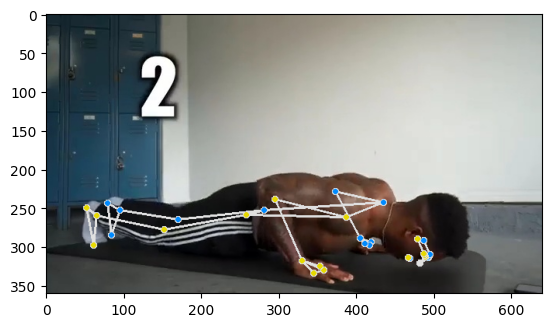

In [39]:
def angle_analysis(image, pose):

    model_path = 'pose_landmarker_heavy.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
    
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to visualize.
        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]

            # Draw the pose landmarks.
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])

        m = np.zeros((33,3))

        for i in range(33):
          pose_landmark = pose_landmarks_list[0][i]
          m[i][0] = float(pose_landmark.x)
          m[i][1] = float(pose_landmark.y)
          m[i][2] = float(pose_landmark.z)

        check = 1

        if(pose==1):
          angles=np.zeros(6)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          angles[4] = calculate_angle_2D(m, 11, 13, 15)
          angles[5] = calculate_angle_2D(m, 12, 14, 16)

          for i in range(len(angles)):
            #print(abs(180 - angles[i]))
            if(abs(180 - angles[i])>30):
              check = 0
              break
          
        else:
          print("cheguei")
          angles=np.zeros(4)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)

          for i in range(len(angles)):
            #print(abs(180 - angles[i]))
            if(abs(180 - angles[i])>30):
              check = 0
              break
        
        
        annotated_image = draw_landmarks_on_image(image.numpy_view(), pose_landmarker_result)

    return check, annotated_image

print(len(index))
path = get_file_path(label, up_down, index[0])
image = mp.Image.create_from_file(path)
check, annotated = angle_analysis(image, 0)
plt.imshow(annotated)

FINAL FUNCTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import glob
import PIL 

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def calculate_angle_2D(m, p1, p2, p3):
    
    point1 = (m[p1][0],m[p1][1])
    point2 = (m[p2][0],m[p2][1])
    point3 = (m[p3][0],m[p3][1])

    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def angle_analysis(file_path, pose):

    model_path = 'pose_landmarker_heavy.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:

        # Load the input image from an image file.
        image = mp.Image.create_from_file(file_path)
    
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to visualize.
        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]

            # Draw the pose landmarks.
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])

        m = np.zeros((33,3))

        for i in range(33):
          pose_landmark = pose_landmarks_list[0][i]
          m[i][0] = float(pose_landmark.x)
          m[i][1] = float(pose_landmark.y)
          m[i][2] = float(pose_landmark.z)

        check = 1

        if(pose=='up'):
          angles=np.zeros(8)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          angles[4] = calculate_angle_2D(m, 11, 13, 15)
          angles[5] = calculate_angle_2D(m, 12, 14, 16)
          angles[6] = calculate_angle_2D(m, 23, 11, 13)
          angles[7] = calculate_angle_2D(m, 24, 12, 14)
          threshold = np.array([20,30,20,30,20,20,20,20])
          mean = np.array([170,165,170,165,170,170,55,55])

          for i in range(len(angles)):
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break
          
        elif(pose=='down'):
          angles=np.zeros(4)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          threshold = np.array([20,20,20,20])
          mean = np.array([170,165,170,165])

          for i in range(len(angles)):
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break

        else:
           print("pose not found")

    return check